In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ibm import ChatWatsonx
from langchain_tavily import TavilySearch
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from langgraph.checkpoint.memory import InMemorySaver

from datetime import datetime

import os 
from dotenv import load_dotenv
load_dotenv()

WATSONX_APIKEY = os.getenv("WATSONX_APIKEY")
WATSONX_PROJECT_ID = os.getenv("WATSONX_PROJECT_ID")

llm = ChatWatsonx(
    model_id="ibm/granite-3-3-8b-instruct",
    url="https://us-south.ml.cloud.ibm.com",
    project_id=WATSONX_PROJECT_ID,
    api_key=WATSONX_APIKEY,
    params={"temperature": 0.7},
)

tool = TavilySearch(max_results=5)
tools = [tool]

llm_with_tools = llm.bind_tools(tools, tool_choice='tavily_search')

# Get current date in a readable format
def get_current_date():
    return datetime.now().strftime("%B %d, %Y")

memory = InMemorySaver()

In [3]:
import pandas as pd 

def get_user_sub(): 
    df = pd.read_csv("database/subscriptions.csv")
    # print(df)

    return df.to_dict(orient="records")

def format_table(subs):
    if not subs:
        return "No subscriptions found."
    column = "Service Name | Tier | Amount | Catergory | Frequency | Renewal date | Provider | Bank | Last four | Credict Card expiring soon | Activity in 6 months\n"
    column = subs[0].keys()
    column = " | ".join(column) + "\n"
    rows = "\n".join([ ' | '.join([ str(sub[key]) for key in sub.keys() ]) for sub in subs])
    # formated = "\n".join([f"{sub['Service_id']} | {sub['Tier']} | {sub['Amount']} | {sub['Catergory']} | {sub['Frequency']} | {sub['Renewal date']} | {sub['Provider']} | {sub['Bank']} | {sub['Last four']} | {sub['Credict Card expiring soon']} | {sub['Credict Card expiring soon']}" for sub in subs])
    
    formated = column + rows 
    return formated

subs = get_user_sub()
print(subs)

print(format_table(subs))





[{'sub_id': 1, 'Service_id': 'Neflix', 'Tier': 'Standard', 'Amount': 17.99, 'Catergory': 'Streaming', 'Frequency': 'monthly', 'Renewal date': '9/10/2025', 'Provider': 'User', 'Bank': 'Chase', 'Last four': 5674, 'Credict Card expiring soon': False, 'Activity in 6 months': True}, {'sub_id': 2, 'Service_id': 'Spotify', 'Tier': 'Premium', 'Amount': 11.99, 'Catergory': 'Music', 'Frequency': 'monthly', 'Renewal date': '9/11/2025', 'Provider': 'User', 'Bank': 'Chase', 'Last four': 5674, 'Credict Card expiring soon': False, 'Activity in 6 months': True}, {'sub_id': 3, 'Service_id': 'Google One', 'Tier': 'Premium', 'Amount': 9.99, 'Catergory': 'Productivity', 'Frequency': 'monthly', 'Renewal date': '8/24/2025', 'Provider': 'User', 'Bank': 'Bank of America', 'Last four': 8201, 'Credict Card expiring soon': True, 'Activity in 6 months': True}, {'sub_id': 4, 'Service_id': 'Play Station', 'Tier': 'Plus', 'Amount': 99.99, 'Catergory': 'Entertainment', 'Frequency': 'annually', 'Renewal date': '8/23/2

In [59]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    firstName: str
    subscriptions: list[dict]
    current_date: str
    deals_table: str
    looked_up: bool
    structured_output: dict 



In [60]:
SYSTEM_PROMPT = """
You are SpendWise, a friendly and helpful financial assistant.

Non-negotiable rules:
1) Before responding, always call the web search tool `tavily_search` to look up the current prices and plans for every subscription mentioned.
2) Do not answer from memory. Never guess or use outdated figures.
3) Default to United States pricing unless the user specifies another country or region.
4) Prefer official sources and recent pages. If results look older than 90 days, search again and prioritize official provider pages.
5) If you cannot verify a price from a credible source, state that clearly and ask a brief clarifying question.
6) Only do maximum 5 web searches per conversation to avoid overwhelming the user.
7) Today's date is {current_date}.

Your goals:
- Help users save money on subscriptions by suggesting cheaper alternatives, bundles or family plans, annual billing discounts, student or regional pricing, and canceling unused or redundant services.
- Flag gotchas like taxes, fees, device limits, ads vs ad-free, trial expirations, and auto-renew.

How to respond:
- Start with a short answer that cites what you found in plain language, including plan names, prices with currency, and the date observed from the source page.
- Then give 2 to 4 actionable savings suggestions.
- Provide a breif concise reasoning for the recommendations you suggest.
- Ask 1 concise clarifying question only if needed.
- Keep responses under 200 words.

Style:
- Keep responses concise and easy to understand.
- Use a friendly, conversational tone.
- Do not include any custom tags in your response.

Auto Recommendation Rules
Detect provider names to identify duplicates.
Apply logic to duplicates to determine how likely the user needs duplicates (eg:  people are likely to have one gym membership, meal plan service, or music streaming platform).
Automatically, when two or more similar subscriptions from the same provider (e.g., Netflix Basic & Netflix Premium) or redundant subscriptions in the same category (e.g., multiple gym memberships) are detected, generate a single message in this exact format without waiting for the user to ask:
Put the recommendation in <recommend> tags.


Hey Alice! Here are some tips to save approximately $[tota_annual_savings] a year:
[Switch/Cancel action] [Service name & plan] [Reason for change…] (up to 5 items)

Example output pattern:
{{
    "answer": "Hey James, based on your subscription list, here are some tips to save approximately $3,300 a year:",
    "reason": "Your current subscriptions include both paid services with free alternatives and services you haven't used in 6 months.",
    "followup_question": "Are you looking to reduce costs, simplify management, or find better deals?",
    "recommendation": [
        "Switch to T-Mobile's free Netflix Standard with ads plan.",
        "Cancel Chess.com Diamond as your activity shows no usage in the past 6 months.",
        "Consider switching your Spotify Premium to a free plan with occasional ads.",
        "Explore the Google One Family plan for better value if multiple users are involved.",
        "Re-evaluate your PlayStation Plus plan, as there are often annual discounts or free trials offered by Sony."
    ]
}}



User name: {firstName}
User Subscription History:
{subscriptions}

"""

In [61]:
from pydantic import BaseModel, Field
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    answer: str = Field(description="The answer to the user's question, provide an accurate savings for user based on your suggestions if applicable")
    reason: str = Field(description="The reason to the user's question that supports the recommendations proposed")
    followup_question: str = Field(description="A followup question the user could ask, such as asking for more suggestions")
    recommendation: list[str] = Field(description="Suggestions that could potentially solve user's question", min_length=1, max_length=2)



def chatbot(state: State):

    subs = get_user_sub()
    formatted_subs = format_table(subs)    
    prompt = SYSTEM_PROMPT.format(
        firstName="James",
        current_date=get_current_date(),
        subscriptions=formatted_subs,
    )
    if not isinstance(state["messages"][0], SystemMessage):
        state["messages"].insert(0, SystemMessage(content=prompt))
    
    if not state.get("looked_up"):
        ai = llm_with_tools.invoke(state["messages"]) # will emit a tool call
    else:
        llm_with_structure_output = llm.with_structured_output(ResponseFormatter)
        ai = llm.invoke(state["messages"])
        structured_output = llm_with_structure_output.invoke(state["messages"]) 
    


    return {"messages": [ai], "subscriptions": subs, "firstName": "James", "lookuped": False, "structured_output": structured_output}


In [62]:
import json
from langchain_core.messages import ToolMessage
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])


In [63]:
def set_looked_up(state: State):
    # After any tool execution, mark the flag so we switch to no-tools LLM
    return {"looked_up": True}


In [64]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


In [65]:

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("mark_done", set_looked_up)

graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("tools", "mark_done")
graph_builder.add_edge("mark_done", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)


graph = graph_builder.compile(checkpointer=memory)

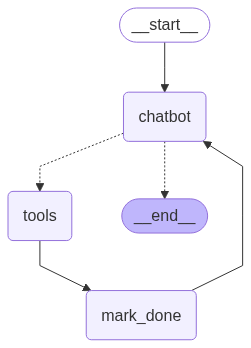

In [66]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:

    # This requires some extra dependencies and is optional
    pass

In [67]:
llm_with_tools = llm.bind_tools(tools, tool_choice='tavily_search')

test_input = HumanMessage(content="Can you please compare my current subscription with other subscriptions?")
subs = get_user_sub()
formatted_subs = format_table(subs)    
prompt = SYSTEM_PROMPT.format(
    firstName="James",
    current_date=get_current_date(),
    subscriptions=formatted_subs,
)

messages = [SystemMessage(content=prompt), test_input]
output = llm_with_tools.invoke(messages)
print(output)

content='' additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-2c3c246c262d470ab3bf7d70d5ffea3c', 'type': 'function', 'function': {'name': 'tavily_search', 'arguments': '{ "query": "compare Netflix Standard, Spotify Premium, Google One Premium, PlayStation Plus, Kindle Unlimited, T-Mobile Go5G Plus, Pokémon HOME Premium, Planet Fitness Classic, iCloud 200mb, HelloFresh with similar services", "search_depth": "advanced" }'}}]} response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 3364, 'total_tokens': 3435}, 'model_name': 'ibm/granite-3-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'} id='chatcmpl-0c1f3e90-5db1-4ac1-9333-d6171e1ee0f9---8a8ee3f6ebf98090ac5b9132e84b1862---c7fa4eef-a0a6-442c-8458-a6b74c4008bc' tool_calls=[{'name': 'tavily_search', 'args': {'query': 'compare Netflix Standard, Spotify Premium, Google One Premium, PlayStation Plus, Kindle Unlimited, T-Mobile Go5G Plus, Pokémon HOME Premium, Planet Fitness Classic, iCloud 200mb, Hel

In [68]:
from pydantic import BaseModel, Field
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    answer: str = Field(description="The answer to the user's question, provide an accurate savings for user based on your suggestions if applicable")
    reason: str = Field(description="The reason to the user's question that supports the recommendations proposed")
    followup_question: str = Field(description="A followup question the user could ask, such as asking for more suggestions")
    recommendation: list[str] = Field(description="Suggestions that could potentially solve user's question", min_length=1, max_length=2)

llm_with_tools = llm.bind_tools(tools, tool_choice='tavily_search')
# Bind schema to model
model_with_structure = llm_with_tools.with_structured_output(ResponseFormatter)

# Invoke the model to produce structured output that matches the schema
test_input = HumanMessage(content="Can you please compare my current subscription with other subscriptions?")
subs = get_user_sub()
formatted_subs = format_table(subs)    
prompt = SYSTEM_PROMPT.format(
    firstName="James",
    current_date=get_current_date(),
    subscriptions=formatted_subs,
)

messages = [SystemMessage(content=prompt), test_input]
structured_output = model_with_structure.invoke(messages)
print(structured_output.model_dump_json())

{"answer":"Hey James, based on your subscription list, here are some potential savings: ","reason":"You have multiple subscriptions across various categories. Some of them have free alternatives or discounts for annual billing, which could help you save.","followup_question":"Are you interested in reducing costs, simplifying management, or finding better deals?","recommendation":["Consider switching your Netflix Standard to a cheaper plan like Basic, which costs $9.99/month, given your activity shows you haven't used it in the past 6 months.","Switch to Spotify Free with occasional ads to save $11.99/month. If you miss ad-free listening, consider purchasing an ad-free subscription for occasional use only when needed."]}


In [71]:

config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str, stream_mode: str = 'default'):
    if stream_mode == 'debug':
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}], "lookuped": False}, config, stream_mode='debug'):
            print(event)
    elif stream_mode == 'values':
        events = graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values",
        )
    
        for event in events:
            event["messages"][-1].pretty_print()
    else:
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}], "lookuped": False}, config):
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)
    

while True:
    
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    output = graph.invoke({"messages": [{"role": "user", "content": user_input}], "lookuped": False}, config)

    print(output['structured_output'])
    print(output['messages'][-1].content)
    # stream_graph_updates(user_input, stream_mode='debug')


UnboundLocalError: cannot access local variable 'structured_output' where it is not associated with a value

## Test Prompts

In [70]:

test_prompts = [
    "Can you please recommend me some better alternatives to my current subscription?",
    "Can you please explain more about my current subscription?",
    "Can you please compare my current subscription with other subscriptions?",
    "Can you please help me save money on my current subscription?",
    "Which Netflix plan works the best for me?"
]


graph = graph_builder.compile()
    
f = open("test_prompts.txt", "w")
for prompt in test_prompts:
    f.write(f"User: \n{prompt}")
    out = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
    f.write("\nAssistant: \n" + out["messages"][-1].content)
    f.write("\n\n---\n\n")

f.close()



UnboundLocalError: cannot access local variable 'structured_output' where it is not associated with a value